# Analyzing whether riders tend to have better results in their home country

load packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import math
from sklearn.utils import resample
import random

load cleaned data (this was done the the expoloratory_data_analyis_and_transformation notebook)

In [2]:
d=pd.read_csv('data/cleaned_downhill_data.csv')
modeling_data=d

## Summary

The primary question we are addressing with this analysis is: Do world cup riders race better or worse in their home country? We are going to operationalize this in four distict ways for our analysis:
1. Across all riders with more than 20 would cup results is the liklehood of rider having a good result relative to their other performances increased when they are racing in their home country?
2. Evaluting riders in the same way is the liklihood of bad results higher for riders racing their home country?
3. Which riders show the biggest positive and negative effects of racing their home country?
4. Are home country racers overrepresented among world cup winners?

# 1.) on average does racing at home increase the liklihood of having a good result?

We define a good result as one in the top 25% of a riders performances and use logistic regression to test this hypothesis (done in prior notebook)

We are going to bootstrapp this so that we can get a confidence interval on the effect of racing at home 

In [3]:

iterations=10000

model_characteristics=pd.DataFrame()
for i in range(iterations):
    
    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train = resample(modeling_data, replace=True, n_samples=int(len(modeling_data)*0.8))
    test = modeling_data[~modeling_data.index.isin(train.index)]
    
    x_train = np.array(train.loc[:, ["home_race"]])
    y_train = np.array(train.loc[:, ["best_results"]])

    x_test = np.array(test.loc[:, ["home_race"]])
    y_test = np.array(test.loc[:, ["best_results"]])

    logreg = LogisticRegression(random_state=16)
    logreg.fit(x_train,np.ravel(y_train))
    out_of_country_prob=math.exp(logreg.intercept_)/(1+math.exp(logreg.intercept_))
    in_country_prob=(math.exp(logreg.intercept_)+logreg.coef_)/(1+math.exp(logreg.intercept_+logreg.coef_))

    output_dict=pd.DataFrame({'Probability_in_country':[in_country_prob.item()],
                              'effect_of_racing_at_home':[math.exp(logreg.coef_)-1],
                              'classificaiton_accuracy':[logreg.score(x_test,np.ravel(y_test))],
                             'Probability_out_of_country':[out_of_country_prob]})
    model_characteristics=pd.concat([model_characteristics,output_dict],axis=0, ignore_index=True)


The estimate of the effect of racing at home is presented here as the increase in the liklihood of a good result when racing in your home country

<AxesSubplot:xlabel='effect_of_racing_at_home', ylabel='Count'>

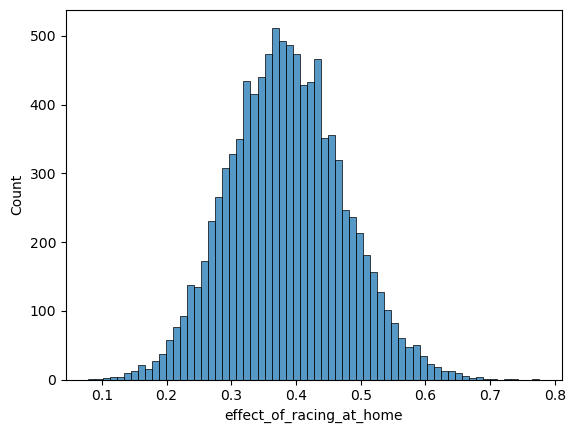

In [4]:
sns.histplot(data=model_characteristics,x='effect_of_racing_at_home')

Median and 95% confinednce intervale of the effect size. Racing at home give you between a 21 and 54% better chance of having a good result

In [5]:
np.quantile(model_characteristics['effect_of_racing_at_home'],[0.025,0.5,0.975])

array([0.21769091, 0.38282397, 0.56334974])

Riders have a higher chance of having a good result when racing in their home country in the rang eof 22 to 26%

## 2.) On average does racing at home give riders a higher liklihood of having a bad result?

Doing the same thing here but changing the response variable to be bad race results 

In [6]:

iterations=10000

model_characteristics_worst=pd.DataFrame()
for i in range(iterations):
    
    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train = resample(modeling_data, replace=True, n_samples=int(len(modeling_data)*0.8))
    test = modeling_data[~modeling_data.index.isin(train.index)]
    
    x_train = np.array(train.loc[:, ["home_race"]])
    y_train = np.array(train.loc[:, ["worst_results"]])

    x_test = np.array(test.loc[:, ["home_race"]])
    y_test = np.array(test.loc[:, ["worst_results"]])

    logreg = LogisticRegression(random_state=16)
    logreg.fit(x_train,np.ravel(y_train))
    out_of_country_prob=math.exp(logreg.intercept_)/(1+math.exp(logreg.intercept_))
    in_country_prob=(math.exp(logreg.intercept_)+logreg.coef_)/(1+math.exp(logreg.intercept_+logreg.coef_))

    output_dict=pd.DataFrame({'Probability_in_country':[in_country_prob.item()],
                              'effect_of_racing_at_home':[math.exp(logreg.coef_)-1],
                              'classificaiton_accuracy':[logreg.score(x_test,np.ravel(y_test))],
                             'Probability_out_of_country':[out_of_country_prob]})
    model_characteristics_worst=pd.concat([model_characteristics_worst,output_dict],axis=0, ignore_index=True)


<AxesSubplot:xlabel='effect_of_racing_at_home', ylabel='Count'>

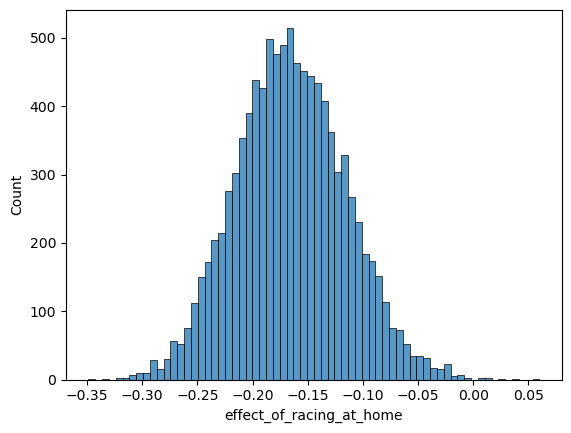

In [7]:
sns.histplot(data=model_characteristics_worst,x='effect_of_racing_at_home')

In [7]:
np.quantile(model_characteristics_worst['effect_of_racing_at_home'],[0.025,0.5,0.975])

array([-0.25757841, -0.16598211, -0.06427769])

Chances of having a bad race result are lower when racing at home by between 3 and 24%

### Graphing results of logistic regressions

In [8]:
graph_data_good=pd.DataFrame({'Location':['Home Country','Away'],
                              'Probability of Good result':[model_characteristics['Probability_in_country'].mean(),
                                                           model_characteristics['Probability_out_of_country'].mean()],
                             'lower_ci':[np.quantile(model_characteristics['Probability_in_country'],0.025),
                                        np.quantile(model_characteristics['Probability_out_of_country'],0.025)],
                             'upper_ci':[np.quantile(model_characteristics['Probability_in_country'],0.975),
                                        np.quantile(model_characteristics['Probability_out_of_country'],0.975)]})

graph_data_bad=pd.DataFrame({'Location':['Home Country','Away'],
                              'Probability of bad result':[model_characteristics_worst['Probability_in_country'].mean(),
                                                           model_characteristics_worst['Probability_out_of_country'].mean()],
                             'lower_ci':[np.quantile(model_characteristics_worst['Probability_in_country'],0.025),
                                        np.quantile(model_characteristics_worst['Probability_out_of_country'],0.025)],
                             'upper_ci':[np.quantile(model_characteristics_worst['Probability_in_country'],0.975),
                                        np.quantile(model_characteristics_worst['Probability_out_of_country'],0.975)]})

Text(0.5, 1.0, 'Good Results')

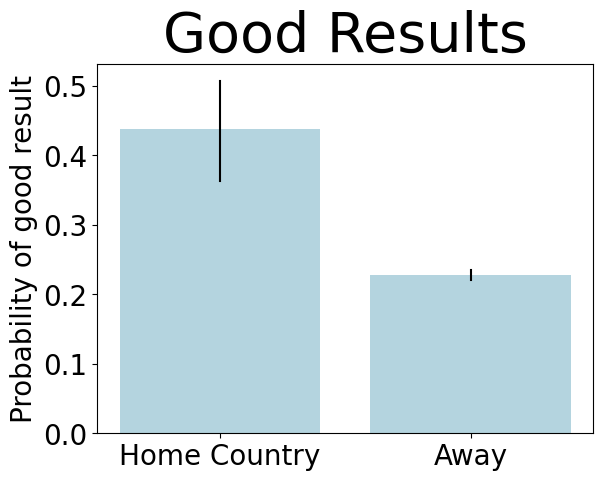

In [9]:
sns.barplot(x="Location", y="Probability of Good result",estimator=np.mean, data=graph_data_good, color='lightblue')
plt.plot(np.asarray([[0, 0], [1, 1]]).T, np.asarray([graph_data_good.iloc[0,2:4], graph_data_good.iloc[1,2:4]]).T, color='black')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("")
plt.ylabel("Probability of good result", fontsize=20)
plt.title('Good Results', fontsize=40)

Text(0.5, 1.0, 'Bad Results')

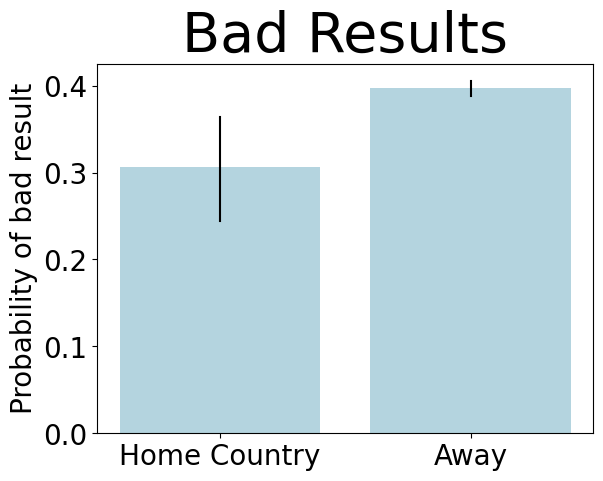

In [10]:
sns.barplot(x="Location", y="Probability of bad result",estimator=np.mean, data=graph_data_bad, color='lightblue')
plt.plot(np.asarray([[0, 0], [1, 1]]).T, np.asarray([graph_data_bad.iloc[0,2:4], graph_data_bad.iloc[1,2:4]]).T, color='black')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("")
plt.ylabel("Probability of bad result", fontsize=20)
plt.title('Bad Results', fontsize=40)

# 3.) which riders show the biggest effects from racing at home?

In [11]:
modeling_names=d['Name'].unique()
rider_models=pd.DataFrame()
for Name in modeling_names:
    one_rider_data=d[d['Name']==Name]
    one_rider_data

    x = np.array(one_rider_data.loc[:, ["home_race"]])
    y_bad = np.array(one_rider_data.loc[:, ["worst_results"]])
    y_good = np.array(one_rider_data.loc[:, ["best_results"]])
    try:
        logreg_bad = LogisticRegression(random_state=16)
        logreg_bad.fit(x,np.ravel(y_bad))
        logreg_good = LogisticRegression(random_state=16)
        logreg_good.fit(x,np.ravel(y_good))
        good_result_effect=math.exp(logreg_good.coef_)-1
        bad_result_effect=math.exp(logreg_bad.coef_)-1
        output_dict=pd.DataFrame({'rider':[Name],'good_result_effect':[good_result_effect],'bad_result_effect':[bad_result_effect]})
        rider_models=pd.concat([rider_models,output_dict],axis=0, ignore_index=True)
    except:
        print(Name,"sum of home races is",one_rider_data['home_race'].sum())

Anne-Caroline CHAUSSON sum of home races is 9
Kristof LENSSENS sum of home races is 0
Marco Aurélio SILVA FIDALGO sum of home races is 0
Robert SMITH (elt) sum of home races is 11
Pavel CEP sum of home races is 0
Gerard WOLFE sum of home races is 7
Ondrej BARTA sum of home races is 0
Markus PLANITZER sum of home races is 4
Iraitz ETXEBARRIA sum of home races is 0
Oliver MORRIS (elt) sum of home races is 2
Niko VELASCO sum of home races is 0


In [13]:
rider_models.set_index('rider')
biggest_effects=rider_models['good_result_effect'].sort_values(ascending=False).head(10)
biggest_effects.index
best_effects=rider_models.loc[biggest_effects.index]
best_effects_riders=best_effects['rider']
best_effects

,rider,good_result_effect,bad_result_effect
162,Jonty NEETHLING,4.207584,-0.751699
338,Rastislav BARANEK,3.209102,-0.417042
244,Joe SMITH (elt),3.171387,-0.542872
199,Ben CATHRO,2.840883,-0.306367
383,Bryan PFEIFFER,2.679183,-0.668003
228,Scott MEARS,2.480423,-0.590074
385,Janis LEHMANN,2.427830,-0.818995
210,Emanuel POMBO,2.318515,-0.502427
349,Lachlan BLAIR,2.266336,-0.690705
320,Fraser MCGLONE,2.257654,-0.673034


In [31]:
bad_results=['DNF','DNQ','DSQ','DNS','',np.nan]
plot_data=d[~d['Run 1'].isin(list(best_effects_riders))]


plot_data['percent_time_back']=plot_data['percent_time_back']+0.008
plot_data.loc[plot_data['Run 1'].isin(list(bad_results)),'percent_time_back']=120+np.random.normal(loc=0, scale=5, size=len(plot_data.loc[plot_data['Run 1'].isin(list(bad_results)),'percent_time_back']))
#plot_data.loc[plot_data['Run 1'].isin(list(bad_results)),'DNF']='yes'
home_races=plot_data[plot_data['home_race']==1]

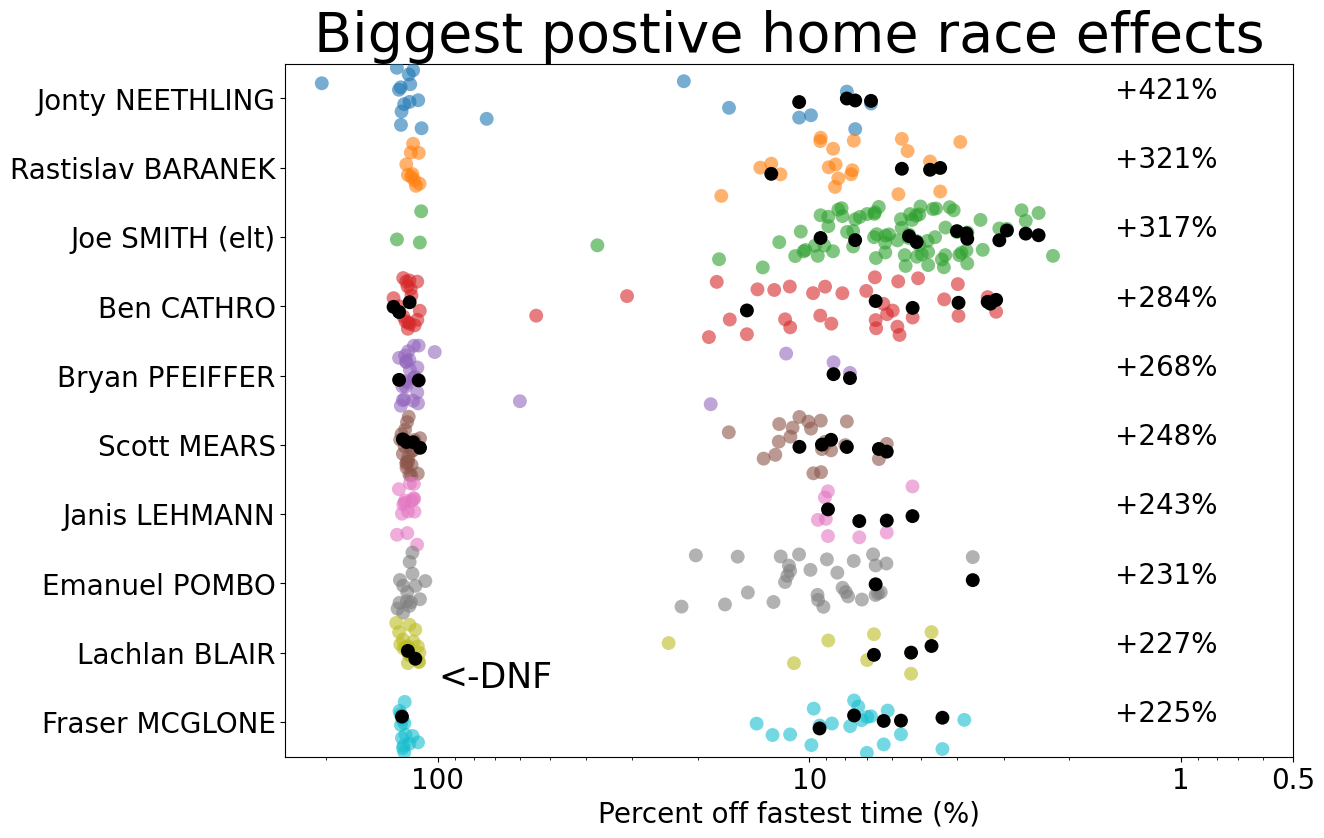

In [33]:
plt.figure(figsize=(13,9))
ax=sns.stripplot(data=plot_data,x='percent_time_back',y="Name",order=list(best_effects_riders),alpha=0.6,
             jitter=0.45,size=10)
sns.stripplot(data=home_races,x='percent_time_back',y="Name",order=list(best_effects_riders),palette=['black'],size=10, ax=ax)
plt.xlabel("Percent off fastest time (%)", fontsize=20)
plt.ylabel("")
plt.title('Biggest postive home race effects', fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale('log')
ax.annotate("<-DNF", xy=(100, 8.5), xycoords='data',fontsize=25)
plt.xticks([0.5,1,10,100],['0.5','1','10','100'])
#plt.axvline(x = 0.008, color = 'b', label = 'Race winning time')
for i in range(10):
    ax.annotate(str("+" + str(int(best_effects['good_result_effect'].iloc[i].round(2)*100))+'%'),
            xy=(1.5, i), xycoords='data',fontsize=20)
    
plt.gca().invert_xaxis()

In [27]:
rider_models.set_index('rider')
biggest_effects=rider_models['bad_result_effect'].sort_values(ascending=False).head(10)
biggest_effects.index
worst_effects=rider_models.loc[biggest_effects.index]
worst_effects_riders=worst_effects['rider']
worst_effects

,rider,good_result_effect,bad_result_effect
63,Glyn O'BRIEN,-0.147111,3.024959
159,Maxime REMY,-0.416668,2.632194
29,Karim AMOUR,-0.259218,2.150784
122,Arnelie THÉVOZ,-0.317148,1.933143
387,Gaetan VIGE,-0.400555,1.902620
91,Sandra WALKER,-0.323658,1.850308
371,Marine CABIROU,-0.361718,1.723848
127,Rüdiger JAHNEL,-0.569158,1.688573
128,Helene Valerie FRUHWIRTH,-0.170577,1.686812
403,Joe BREEDEN,-0.367458,1.652283


In [34]:
bad_results=['DNF','DNQ','DSQ','DNS','',np.nan]
plot_data=d[~d['Run 1'].isin(list(worst_effects_riders))]


plot_data['percent_time_back']=plot_data['percent_time_back']+0.008
plot_data.loc[plot_data['Run 1'].isin(list(bad_results)),'percent_time_back']=120+np.random.normal(loc=0, scale=5, size=len(plot_data.loc[plot_data['Run 1'].isin(list(bad_results)),'percent_time_back']))
#plot_data.loc[plot_data['Run 1'].isin(list(bad_results)),'DNF']='yes'
home_races=plot_data[plot_data['home_race']==1]

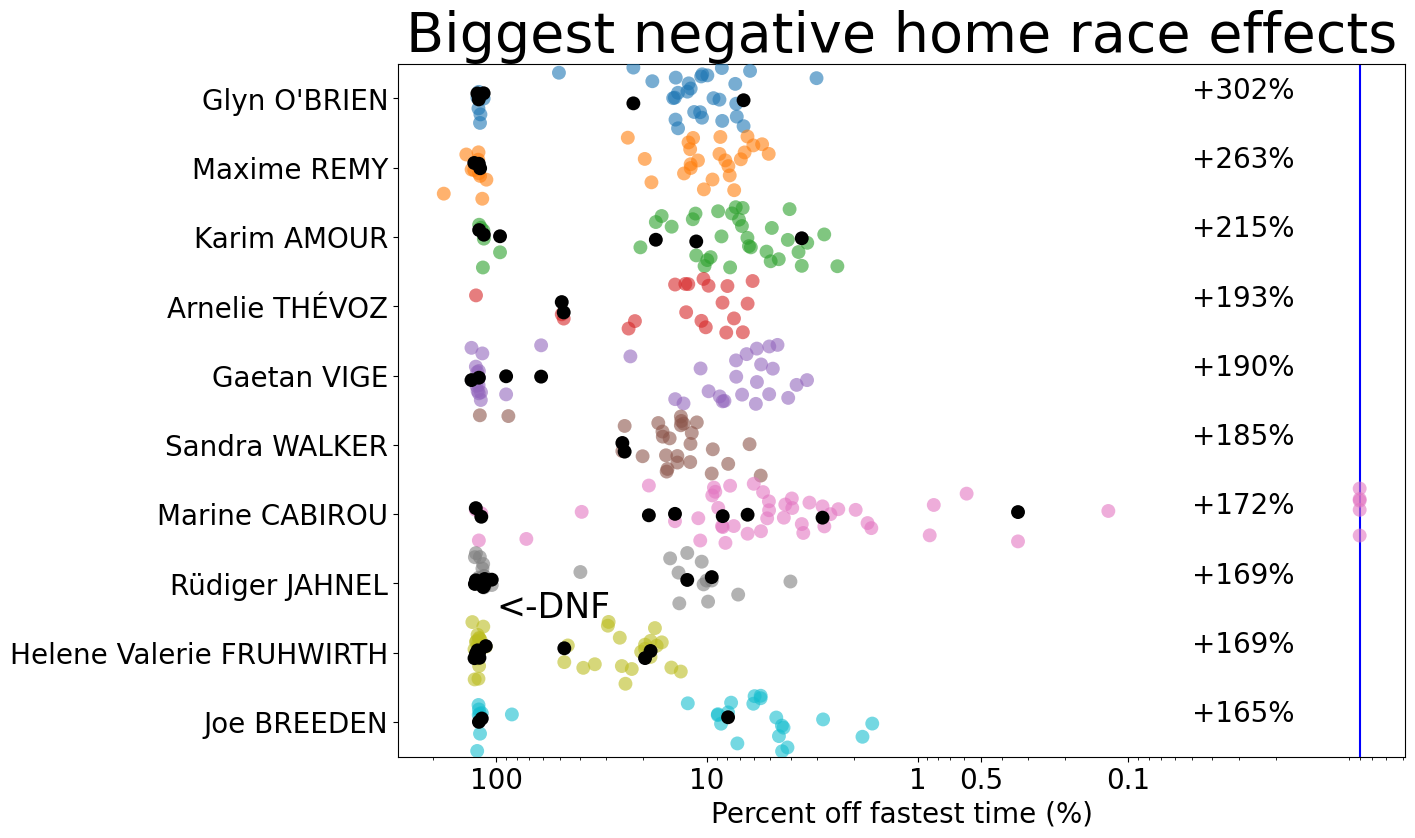

In [38]:
plt.figure(figsize=(13,9))
ax=sns.stripplot(data=plot_data,x='percent_time_back',y="Name",order=list(worst_effects_riders),alpha=0.6,
             jitter=0.45,size=10)
sns.stripplot(data=home_races,x='percent_time_back',y="Name",order=list(worst_effects_riders),palette=['black'],size=10, ax=ax)
plt.xlabel("Percent off fastest time (%)", fontsize=20)
plt.ylabel("")
ax.annotate("<-DNF", xy=(100, 7.5), xycoords='data',fontsize=25)
plt.title('Biggest negative home race effects', fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale('log')
plt.xticks([0.1,0.5,1,10,100],['0.1','0.5','1','10','100'])
plt.axvline(x = 0.008, color = 'b', label = 'Race winning time')
for i in range(10):
    ax.annotate(str("+" + str(int(worst_effects['bad_result_effect'].iloc[i].round(2)*100))+'%'),
            xy=(0.05, i), xycoords='data',fontsize=20)
    
plt.gca().invert_xaxis()

# 4.) Are home country winners overrepresented in world cup results?

In [39]:
winners=d[d['percent_time_back']==0]
men_winners=winners[winners['sex']=='Men']
women_winners=winners[winners['sex']=='Women']

How many wins were in a home country?

In [40]:
print(men_winners['home_race'].sum(),'men won at home')
print(women_winners['home_race'].sum(),'women won at home')

21 men won at home
24 women won at home


In [ ]:
iterations=10000
randomization_test=pd.DataFrame()
men_races=list(men_winners['race_country'])
women_races=list(women_winners['race_country'])

for i in range(iterations):
    mens=sum(men_winners['rider_country_new']==random.sample(list(men_winners['race_country']),len(list(men_winners['race_country']))))
    womens=sum(women_winners['rider_country_new']==random.sample(list(women_winners['race_country']),len(list(women_winners['race_country']))))
    output=pd.DataFrame({'mens':[mens],'womens':[womens]})
    randomization_test=pd.concat([randomization_test,rider_models,output],axis=0, ignore_index=True)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


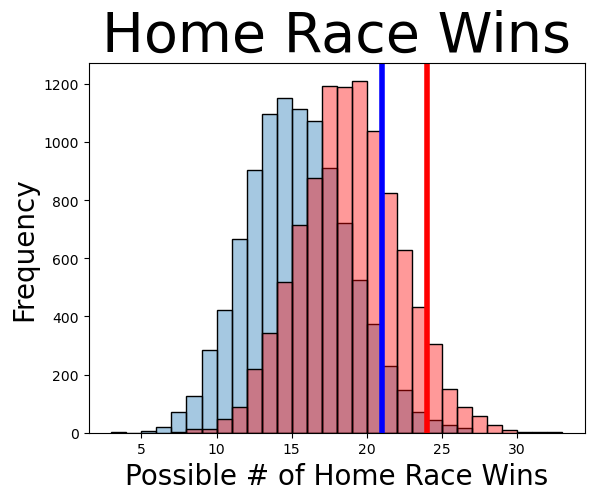

In [22]:
ax=sns.histplot(data=randomization_test,x='mens',alpha=0.4,binwidth=1)
sns.histplot(data=randomization_test,x='womens',alpha=0.4,ax=ax,color='red',binwidth=1)
plt.xlabel("Possible # of Home Race Wins", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title('Home Race Wins', fontsize=40)
plt.axvline(x = 24, color = 'red', label = 'Race winning time',linewidth=4)
plt.axvline(x = 21, color = 'blue', label = 'Race winning time',linewidth=4)

In [23]:
len(randomization_test[randomization_test['mens']<21])/iterations

0.9464

In [24]:
len(randomization_test[randomization_test['womens']<21])/iterations

0.7472

In [25]:
rider_models[rider_models['good_result_effect']>0]

,rider,good_result_effect,bad_result_effect
2,Tomas MISSER,0.149931,0.149931
3,Scott SHARPLES,0.847912,-0.197078
4,Christian TAILLEFER,0.154283,-0.416754
8,Myles ROCKWELL,1.475244,-0.522454
10,Michael RONNING,0.824224,-0.204395
...,...,...,...
395,Matt WALKER (elt),1.317398,-0.484127
398,Hugo FRIXTALON,0.135878,-0.375159
401,Melanie CHAPPAZ,0.539042,-0.656584
410,Mikayla PARTON,0.718629,-0.193779


In [26]:
rider_models

,rider,good_result_effect,bad_result_effect
0,Nicolas VOUILLOZ,-0.457799,0.966453
1,Mike KING (pro),-0.022155,-0.482357
2,Tomas MISSER,0.149931,0.149931
3,Scott SHARPLES,0.847912,-0.197078
4,Christian TAILLEFER,0.154283,-0.416754
...,...,...,...
409,Benjamin ZWAR KVIST,0.000000,0.000000
410,Mikayla PARTON,0.718629,-0.193779
411,Thibaut DAPRELA,0.212550,0.000003
412,Kye A'HERN,0.000000,0.000000


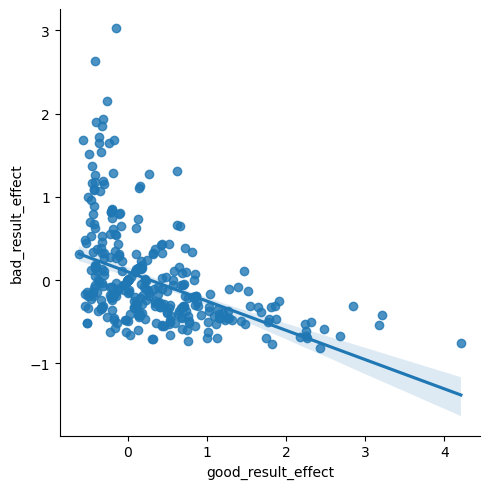

In [27]:
sns.lmplot(
    data=rider_models,
    x="good_result_effect", y="bad_result_effect"
)

In [28]:
rider_models[(rider_models['good_result_effect']>0) & (rider_models['bad_result_effect']>0)]

,rider,good_result_effect,bad_result_effect
2,Tomas MISSER,0.149931,0.149931
15,John TOMAC,0.097735,0.097735
27,Markus PETSCHENIG,0.809514,0.342380
28,Michael GÖLLES,0.522854,0.428568
32,Leigh DONOVAN,0.691630,0.083884
34,Giovanna BONAZZI,0.156807,0.156807
35,Missy GIOVE,0.039296,0.039296
45,Sean MCCARROLL,0.143844,1.106486
55,Mami MASUDA,0.138621,0.138621
67,Marielle SANER,0.158584,1.127544


In [29]:
len(d)

18888

In [30]:
d.head()

,Unnamed: 0,Name,Name.1,Run 1,sex,rider_country,race_country,Date,track_name,rider_country_new,home_race,run_time,race_id,percent_time_back,best_results,worst_results
0,0,Nicolas VOUILLOZ,Nicolas VOUILLOZ,5:57.981,Men,French,Germany,23rd Sep 1995,Kirchzarten,France,0,5.966350,Kirchzarten23rd Sep 1995,0.000000,1,0
1,2,Mike KING (pro),Mike KING (pro),6:07.083,Men,American,Germany,23rd Sep 1995,Kirchzarten,USA,0,6.118050,Kirchzarten23rd Sep 1995,2.542593,1,0
2,3,Tomas MISSER,Tomas MISSER,6:10.384,Men,Spanish,Germany,23rd Sep 1995,Kirchzarten,Spain,0,6.173067,Kirchzarten23rd Sep 1995,3.464709,0,0
3,4,Scott SHARPLES,Scott SHARPLES,6:11.405,Men,Australian,Germany,23rd Sep 1995,Kirchzarten,Australia,0,6.190083,Kirchzarten23rd Sep 1995,3.749920,0,0
4,5,Christian TAILLEFER,Christian TAILLEFER,6:12.916,Men,French,Germany,23rd Sep 1995,Kirchzarten,France,0,6.215267,Kirchzarten23rd Sep 1995,4.172009,1,0


In [31]:
graph_data_good

,Location,Probability of Good result,lower_ci,upper_ci
0,Home Country,0.438117,0.362925,0.507384
1,Away,0.227278,0.220420,0.234198


In [32]:
len(winners['rider_country'].unique())

13

In [33]:
rider_models.to_csv("data/rider_home_race_effects.csv")

OSError: [Errno 28] No space left on device